# Task 2. Examine your network

Examine the network and analyze how it processes the data.
Read in the trained network as the first step and print the model.

This should show you the structure of the network and the name of each layer.

In [1]:
import sys
import math
import nbimporter
import Task1AE as Note1AE
import Task1FG as Note1FG

import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt


## A. Analyze the first layer

Get the weights of the first layer.

When accessing a network, use the name of the layer as specified in the model printout. In this case, the name should be conv1. You access the weights using model.conv1.weight. The result is a tensor that should have the shape [10, 1, 5, 5]. That means there are ten filters, each 5x5 in size. To access the ith 5x5 filter, use weights[i, 0]. Print the filter weights and their shape.

Visualize the ten filters using pyplot.

You can use the pyplot functions figure, subplot, and imshow to make a 3x4 grid of figures such as the image below. If you set xticks and yticks to the empty list [], it will give you a cleaner plot.

In [12]:
# A. Analyze the first layer
def analyze_1st_layer(network):
    """
    Will take a network, grab the first layer of 10 filter and plot
    """
    figure = plt.figure(figsize=(8, 8))
    weights = network.conv1.weight

    for i in range(10):
        # 1. Prepare grid
        plt.subplot(4, 4, i+1)
        plt.tight_layout()

        # 2. make sure the shape is 5X5 before doing imshow
        filter_matrix = weights[i][0].detach().numpy()
        # print("\n10 of 5X5 filter:", filter_matrix)
        print("shape", filter_matrix.shape)

        # 3. show
        figure.suptitle("first layer of 10X5X5 filter", fontsize=16)
        plt.imshow(filter_matrix, interpolation="none")
        plt.xticks([])

## B. Show the effect of the filters to the first training image

Use OpenCV's filter2D function to apply the 10 filters to the first training example image.

Generate a plot of the 10 filtered images such as the one below. When working with the weights, you will need to tell pyTorch it does not need to calculate gradients. 


In [15]:
def apply_first_filter_plot(network, img):
    """
    Will take a network, plot each filter on 1 column
    and  plot the result of applying the filter on an image
    """
    # 1. apply first conv filter to the image
    with torch.no_grad():
        network.eval()
        output = network.conv1(img)
        print(output.shape)

    # 2. plot
    figure = plt.figure(figsize=(10, 10))
    img_index = 0
    plot_index = 1 # total 20 plots
    figure.suptitle("filter5X5 and output 24X24", fontsize=16)

    # 3. get filter
    weights = network.conv1.weight
    print("weights shape: ", weights.shape)
    while(img_index < 10):
        # - draw filter
        plt.subplot(5, 4, plot_index)
        plt.tight_layout()
        filter_matrix = weights[img_index][0].detach().numpy()
        plt.imshow(filter_matrix, cmap = 'gray', interpolation="none")
        plt.title("filter:%d" %(img_index))
        plt.xticks([])

        plot_index+=1

        # - draw output after filter
        plt.subplot(5, 4, plot_index)
        plt.tight_layout()
        output_matrix = output[img_index]
        plt.title("output:%d" %(img_index))

        plt.imshow(output_matrix, cmap='gray',interpolation="none")
        plt.xticks([])

        img_index +=1
        plot_index+=1   

# C. Build a truncated model
Build a new model using only the first two convolutional layers. A simple way to do this is to create a subclass of the Net class you created where the forward function is only the first two steps.

Try modifying the forward function so it returns after only the first layer. Double-check that these look like filtered versions of the input image.

In [4]:
class SubmodelConv2(Note1AE.NeuralNetwork):
    """
    A class tht only has the first two of convl. layer from the imported network
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward( self, x ):
        
        # relu on max pooled results of conv1
        x = F.relu( F.max_pool2d( self.conv1(x), 2 ) ) 
        # relu on max pooled results of dropout of conv2
        x = F.relu( F.max_pool2d( self.conv2_drop( self.conv2(x)), 2 ) ) 
        return x
    
    
    
class SubmodelConv1(Note1AE.NeuralNetwork):
    """
    A class tht only has the first convl. layer from the imported network
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward( self, x ):
        
        # relu on max pooled results of conv1
        x = F.relu( F.max_pool2d( self.conv1(x), 2 ) ) 
        return x
    
    
def run_subnetwork_and_plot(subnetwork, img, num_conv):
    """
    Run subnetwork on an image and plot the result
    
    Args:
    num_layer: the number of conv. layer in the subnetwork
    """
    
    
    # 1. load the state dictionary you read from the file. 
    Note1FG.load_network_state(subnetwork)
    outputSub = Note1FG.run_network(subnetwork, img)

    # 2. plot the ouput after running the sub network
    size_r= 10
    size_c = 10
    figure = plt.figure(figsize=(size_r, size_c))
    
    if (num_conv == 1):
        output_dim = "20X4X4"
    else:
        output_dim = "10X12X12"
        
    title = "output after "+ str(num_conv) + " layers : " + str(output_dim) +" filter"
    print(title)
    figure.suptitle(title, fontsize=16)

    for i in range(len(outputSub)):
        row_col = math.ceil(math.sqrt(len(outputSub)))
        # - set the fig
        plt.subplot(row_col, row_col, i+1)
        plt.tight_layout()
        plt.imshow(outputSub[i], cmap = 'gray', interpolation='none')

        # - remove x, y values
        plt.xticks([])

In [16]:
def main(argv):
    # - init network from the last saved
    network = Note1FG.load_network_state(Note1AE.NeuralNetwork())
    
    # Task A
    print("\nA. Analyze first filter")
    analyze_1st_layer(network)
    
    # Task B
    print("\nB. Apply filter to first training image")
    # - get the first training image (1X28X28) 
    train_loader = Note1AE.get_loader(is_train=True)
    img = Note1FG.load_firstN_data(train_loader, 1)[0]
    print("image shape:", img.shape)
    plt.imshow(img[0], cmap='gray', interpolation='none')
    
    apply_first_filter_plot(network, img)
    
    # Task C
    # Creat subnetwork of only the first 2 convl. layer, run, and plot the filter
    print("\nC. Create subnetwork of only convl. layers and plot the result")
    sub2 = SubmodelConv2()
    run_subnetwork_and_plot(sub2, img, num_conv=2)
    
    
    # Task D
    sub1 = SubmodelConv1()
    run_subnetwork_and_plot(sub1, img, num_conv=1)


A. Analyze first filter
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)
shape (5, 5)

B. Apply filter to first training image
image shape: torch.Size([1, 28, 28])
torch.Size([10, 24, 24])
weights shape:  torch.Size([10, 1, 5, 5])

C. Create subnetwork of only convl. layers and plot the result
output after 2 layers : 10X12X12 filter
output after 1 layers : 20X4X4 filter


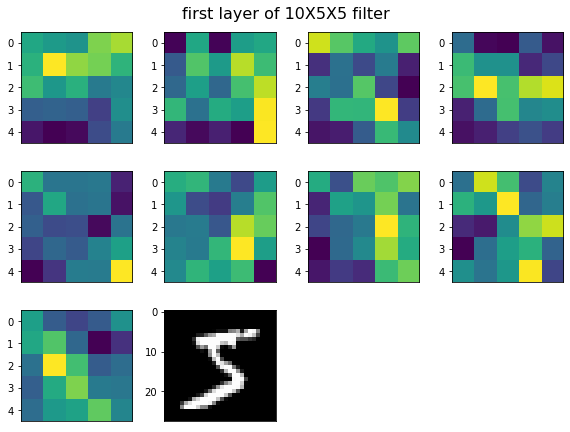

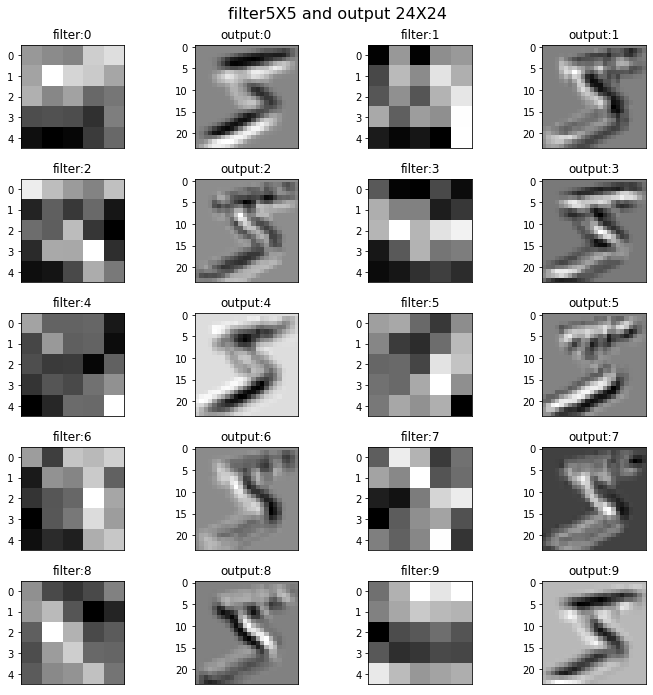

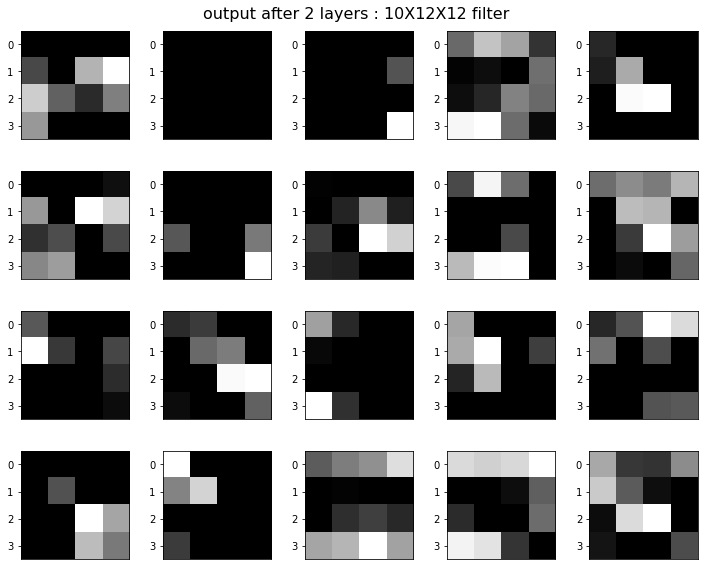

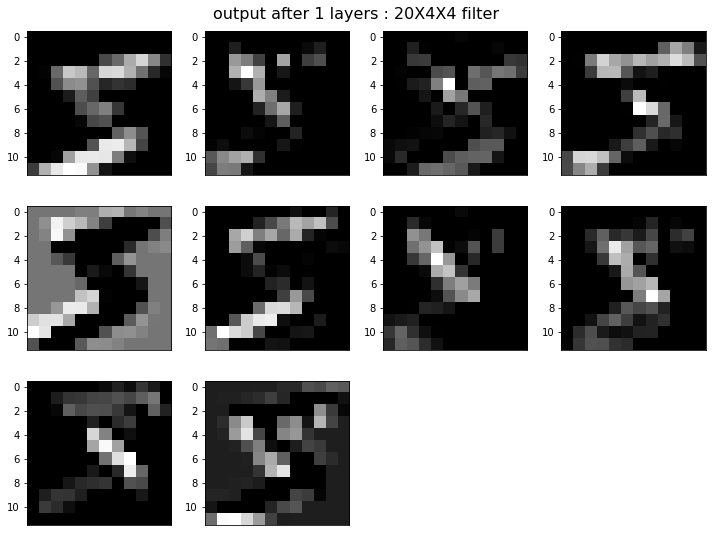

In [17]:
if __name__ == "__main__":
    
    main(sys.argv)